# Problem statement

### Equation problem

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_\inf}{T_{b} - T_{\inf}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_\inf)}$


- $\epsilon_G=\epsilon(T_b-T_\inf)$


- $\epsilon_C=\beta(T_b-T_\inf)$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$

In [1]:
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K

In [2]:
import torch
import imageio
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from torch.optim import SGD, LBFGS, Adam, RMSprop, SparseAdam
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Load Data

In [3]:
## Load dataset
relative_csv_path = "./../src/data/raw/Dataset.csv"
split_ratio = 0.2

# Load different temperatures samples 
fields = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
df_T = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
X_train, X_test = train_test_split(df_T, test_size = split_ratio)

# Load different G values 
fields = ['G']
df_G = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
Y_train, Y_test = train_test_split(df_G, test_size = split_ratio)

### Print shape and sizes
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
Y_train = Y_train.to_numpy()
Y = df_T.to_numpy()

# Compute columns shampes

# print("X_test information:")
# print("the size of X_test is", X_test.size)
# print("the shape of X_test is", X_test.shape)

# print("X_train information:")
# print("the size of X_train is", X_train.size)
# print("the shape of X_train is", X_train.shape)

# print("Y_train information:")
# print("the size of Y_train is", Y_train.size)
# print("the shape of Y_train is", Y_train.shape)

# print("Y_test information:")
# print("the size of Y_test is", Y_test.size)
# print("the shape of Y_test is", Y_test.shape)


### Compute $\theta$ as `X_train`
X_train = np.multiply(np.add(X_train, [-T_inf]), [1/(T_b - T_inf)])
X_test = np.multiply(np.add(X_test, [-T_inf]), [1/(T_b - T_inf)])

In [15]:
"hola pedirn {}".format(1)

'hola pedirn 1'

In [59]:
# Normalize
def normalize(xi, xmax, xmin):
    return 2 * (xi - xmin) / (xmax - xmin) - 1
  
### Reduce the training set
def train_test_model(num_data_training, num_of_neurons, num_epochs, X_train, Y_train, X_test, Y_test):
    """
    """
        
    X_train_reduced = X_train[:num_data_training,1:]
    Y_train_reduced = Y_train[:num_data_training]

    num_col_Xr = X_train_reduced.shape[1]
    num_col_Y = Y_train_reduced.shape[1]
    min_x_train = [np.min(X_train_reduced[:,col_T]) for col_T in range(num_col_Xr)]
    max_x_train = [np.max(X_train_reduced[:,col_T]) for col_T in range(num_col_Xr)]

    normalized_X_reduced_train = np.copy(X_train_reduced)
    normalized_Y_reduced_train = np.copy(Y_train_reduced) # TOOO: No queremos normalizar
    
    for col in range(num_col_Xr): 
      for row in range(num_data_training):
        normalized_X_reduced_train[row,col] = normalize(X_train_reduced[row,col], min_x_train[col] , max_x_train[col])
        

    # Copy into torch x_train and y_train 
    x = torch.from_numpy(normalized_X_reduced_train[:,0].reshape(-1,1)).float()
    y = torch.from_numpy(normalized_Y_reduced_train.reshape(-1,num_col_Y)).float()
    
    # Define model architecture 
    Inputs = x.size(1)
    Net = torch.nn.Sequential(
          torch.nn.Linear(Inputs, num_of_neurons),
          torch.nn.Tanh(),
          torch.nn.Linear(num_of_neurons, num_of_neurons),
          torch.nn.Tanh(),
          torch.nn.Linear(num_of_neurons, num_of_neurons),
          torch.nn.Tanh(),
          torch.nn.Linear(num_of_neurons, num_of_neurons),
          torch.nn.Tanh(),
#           torch.nn.Linear(num_of_neurons, num_of_neurons),
#           torch.nn.Tanh(),
#           torch.nn.Linear(num_of_neurons, num_of_neurons),
#           torch.nn.Tanh(),
#           torch.nn.Linear(num_of_neurons, num_of_neurons),
#           torch.nn.Tanh(),
#           torch.nn.Linear(num_of_neurons, num_of_neurons),
#           torch.nn.Tanh(),
          torch.nn.Linear(num_of_neurons, num_of_neurons),
          torch.nn.Tanh(),
          torch.nn.Linear(num_of_neurons, num_col_Y))
    
    # Watch x,y 
    x = Variable(x)
    y = Variable(y)
    
    # Loss Function
    loss_function = torch.nn.MSELoss()
    LearningRate = 1e-3
    adam_only_loss = np.zeros(num_epochs)

    # Define optimizer
    optimizer_adam = torch.optim.Adam(Net.parameters(), lr = LearningRate)
#     optimizer_lbfgs = LBFGS(Net.parameters(), history_size=5, max_iter=6)

    # Image 
    fig, ax = plt.subplots(figsize=(15,10))
    image_list = []

    
    for it in range(num_epochs):
        y_pred = Net(x)
        loss = loss_function(y_pred, y)  # Notice the order: NN Pred first and then actual value
        optimizer_adam.zero_grad()       # Zero Out the gradient
        loss.backward()
        optimizer_adam.step()    
        #optimizer.step(closure)
        #loss = closure()
        adam_only_loss[it] = loss.detach().numpy()
        y_pred = Net(x)
        y_test = y_pred.detach().numpy()
        
        # Print image
        if it%20==0:
            plt.cla()
            ax.set_xlabel('x', fontsize=32)
            ax.set_ylabel('y', fontsize=32)
            ax.set_xlim(-1, 1)
#             ax.set_ylim(-1, 1)
            ax.scatter(normalized_X_reduced_train[:,0], normalized_Y_reduced_train, color = "red", label="Training Data")
            ax.plot(normalized_X_reduced_train[:,0], y_test, 'k--', lw=2,  label="NN Apprximated")
            ax.text(-3, 6.0, 'Adam Optimizer: It = %d,' %it, fontdict={'size': 22, 'color':  'black'})
            ax.text(0.5, 6.0, 'Loss = %.6f' % loss,
                    fontdict={'size': 22, 'color':  'black'})
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.legend()

            fig.canvas.draw()      
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            image_list.append(image)

    name = './Adam_func_{}.gif'.format(num_data_training)
    imageio.mimsave(name, image_list, fps=5)
        
    print(f"With num_data_training: {num_data_training} the loss is: {loss:.5e}")

    
    # Compute test error 
    
    # Normalize
    X_test_reduced = X_test[:num_data_training,1:]
    normalized_X_test = np.copy(X_test_reduced)
    for col in range(normalized_X_test.shape[1]): 
      for row in range(normalized_X_test.shape[0]):
        normalized_X_test[row,col] = normalize(normalized_X_test[row,col], min_x_train[col] , max_x_train[col])
    
    # Copy into torch x_test and y_test 
    x_test = torch.from_numpy(normalized_X_test[:,0].reshape(-1,1)).float()
    y_test = torch.from_numpy(Y_test.reshape(-1,num_col_Y)).float()


    # Compute y predict
    y_nn = Net(x_test)
    print(y_nn.shape)
    error_test = loss_function(y_nn, y_test).detach().numpy()  # Notice the order: NN Pred first and then actual value
    
    
    return adam_only_loss, error_test





With num_data_training: 100 the loss is: 5.47795e-02
torch.Size([100, 1])
With num_data_training: 170 the loss is: 6.74909e-02
torch.Size([100, 1])
With num_data_training: 240 the loss is: 6.55976e-02
torch.Size([100, 1])
With num_data_training: 310 the loss is: 6.58017e-02
torch.Size([100, 1])
With num_data_training: 380 the loss is: 6.38934e-02
torch.Size([100, 1])


[array(0.09195011, dtype=float32),
 array(0.0769137, dtype=float32),
 array(0.07791257, dtype=float32),
 array(0.07371032, dtype=float32),
 array(0.07226454, dtype=float32)]

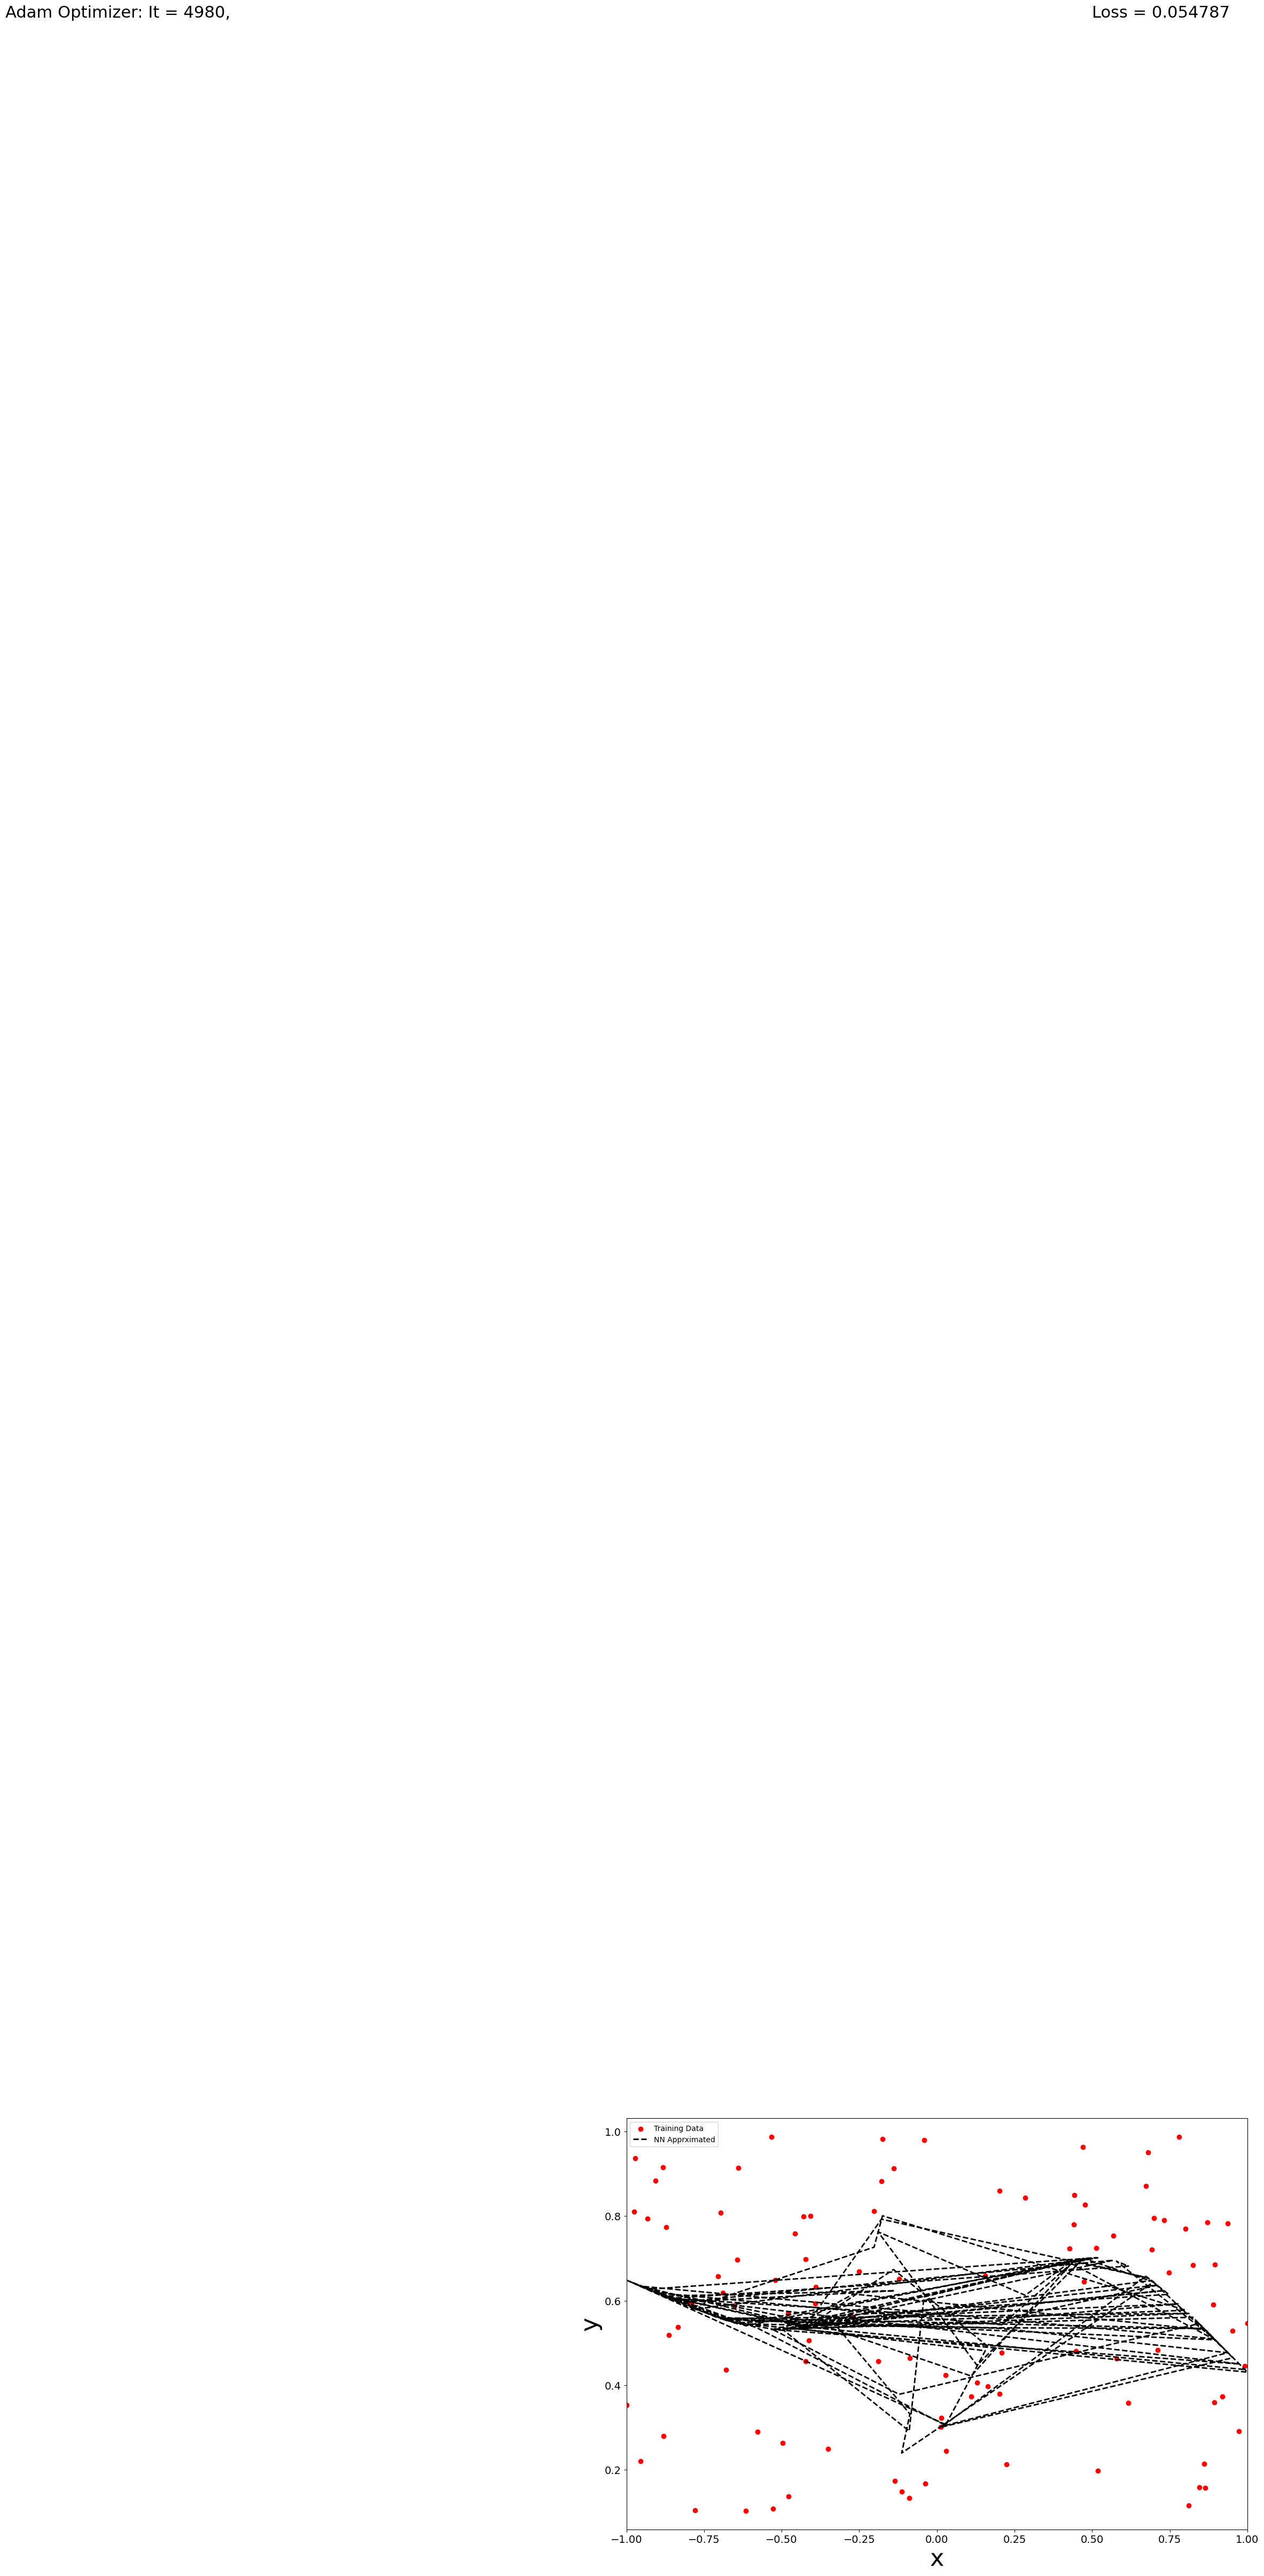

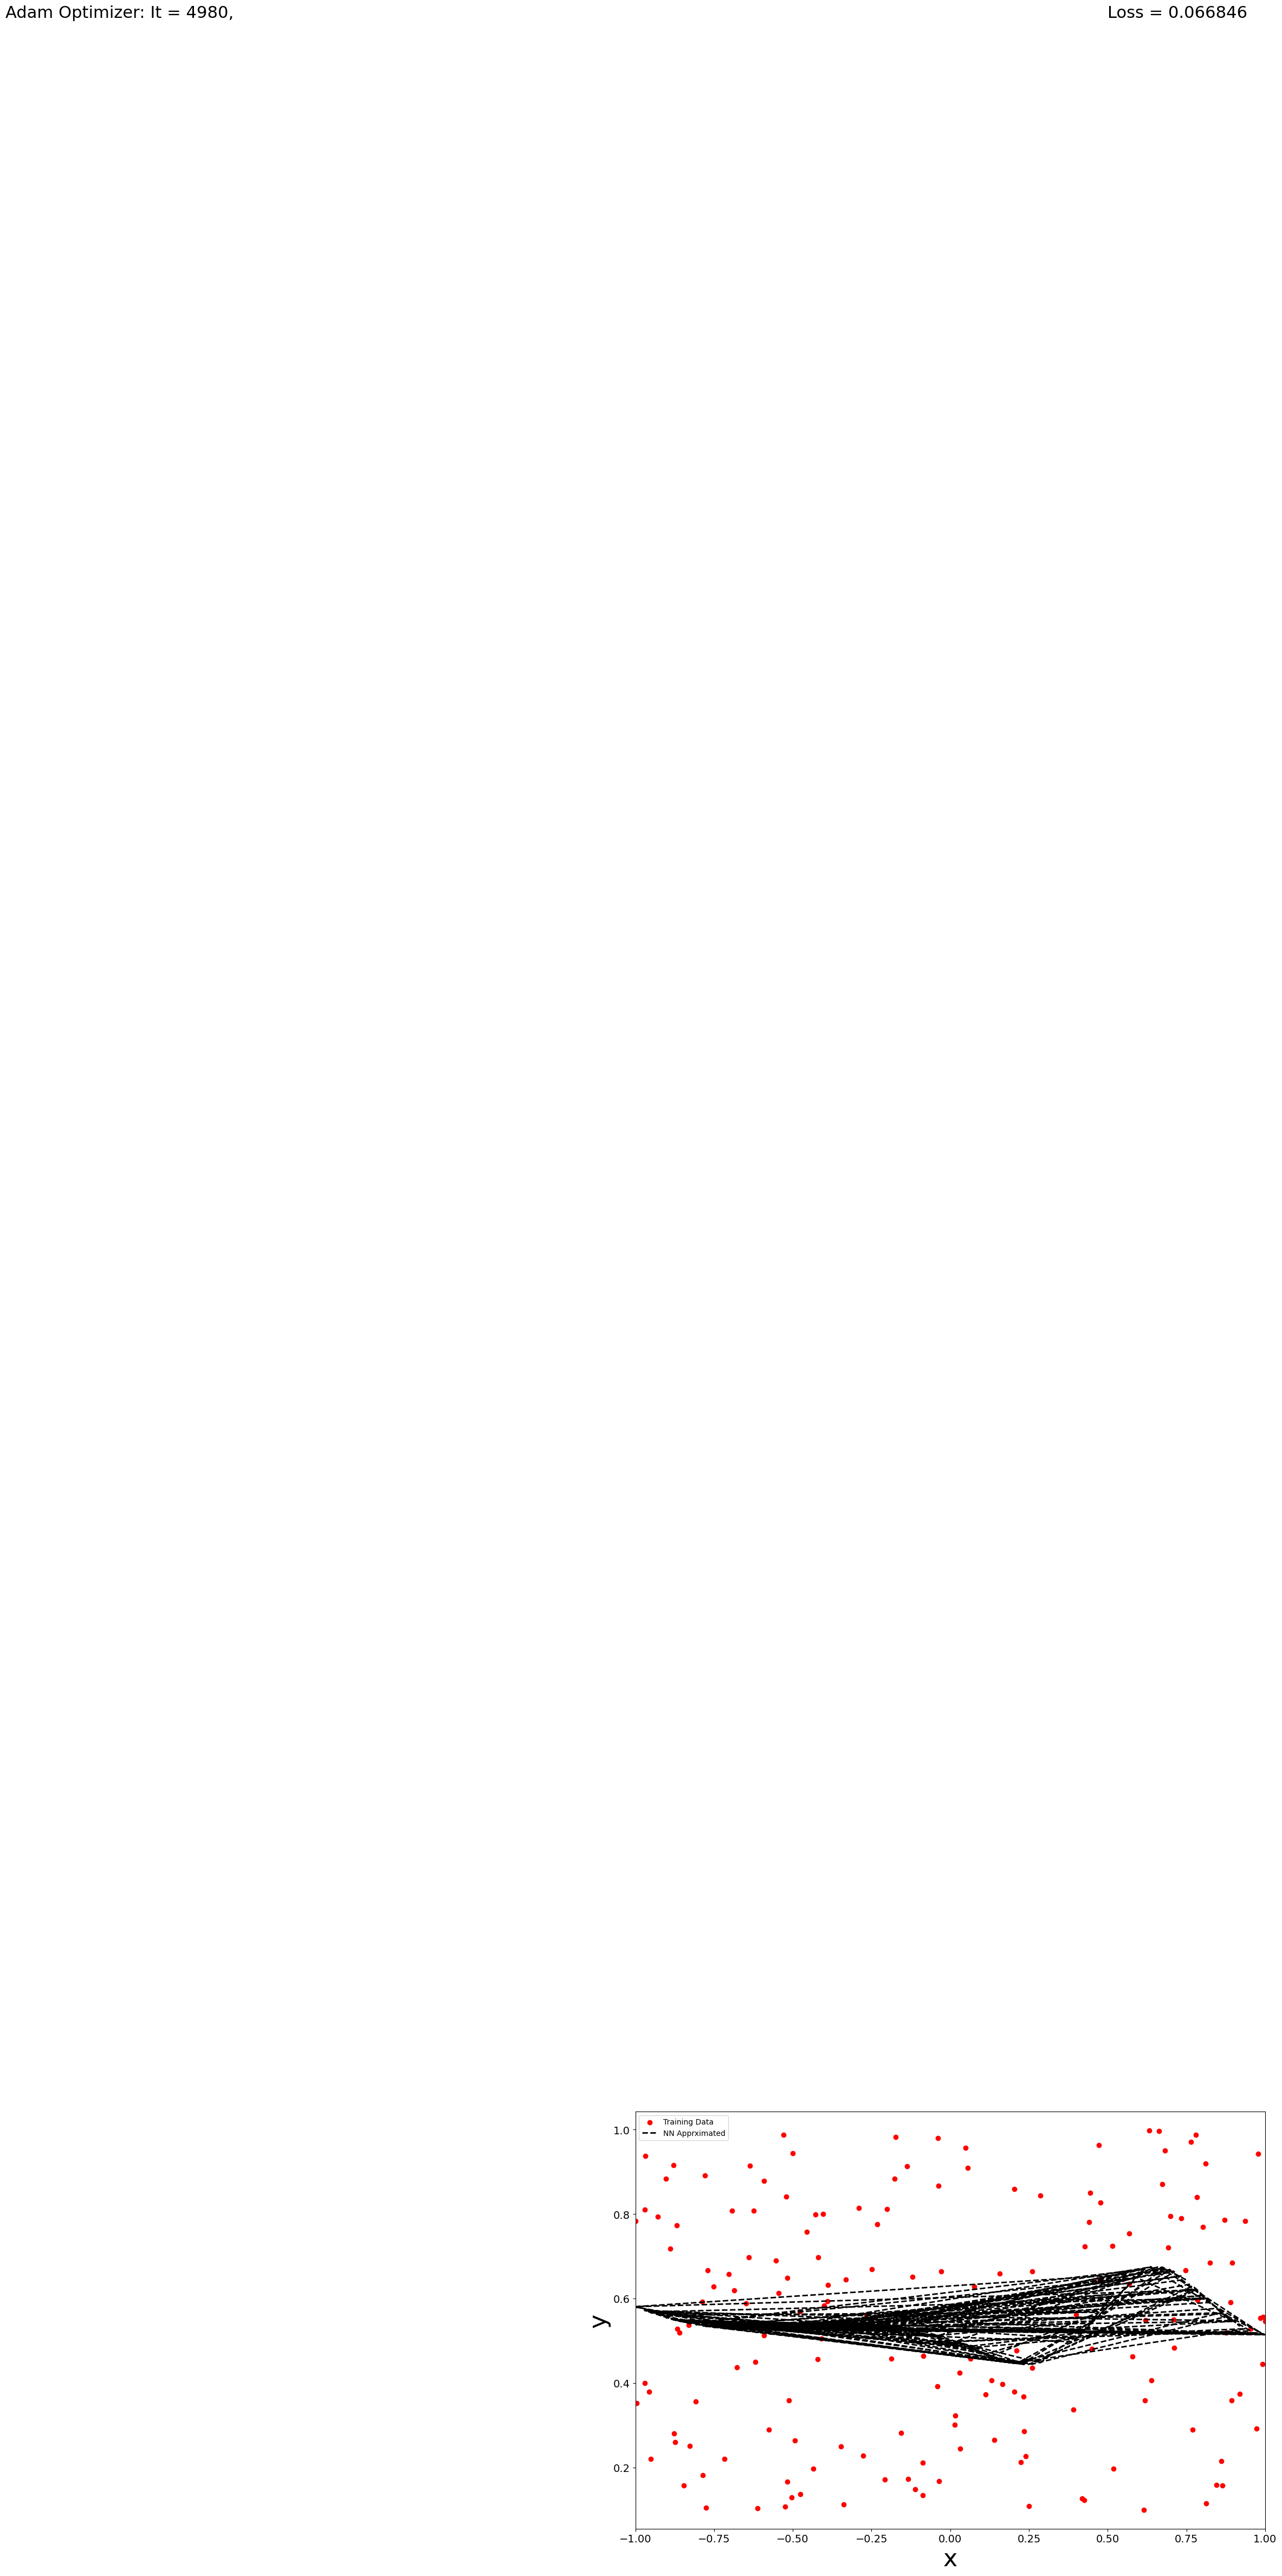

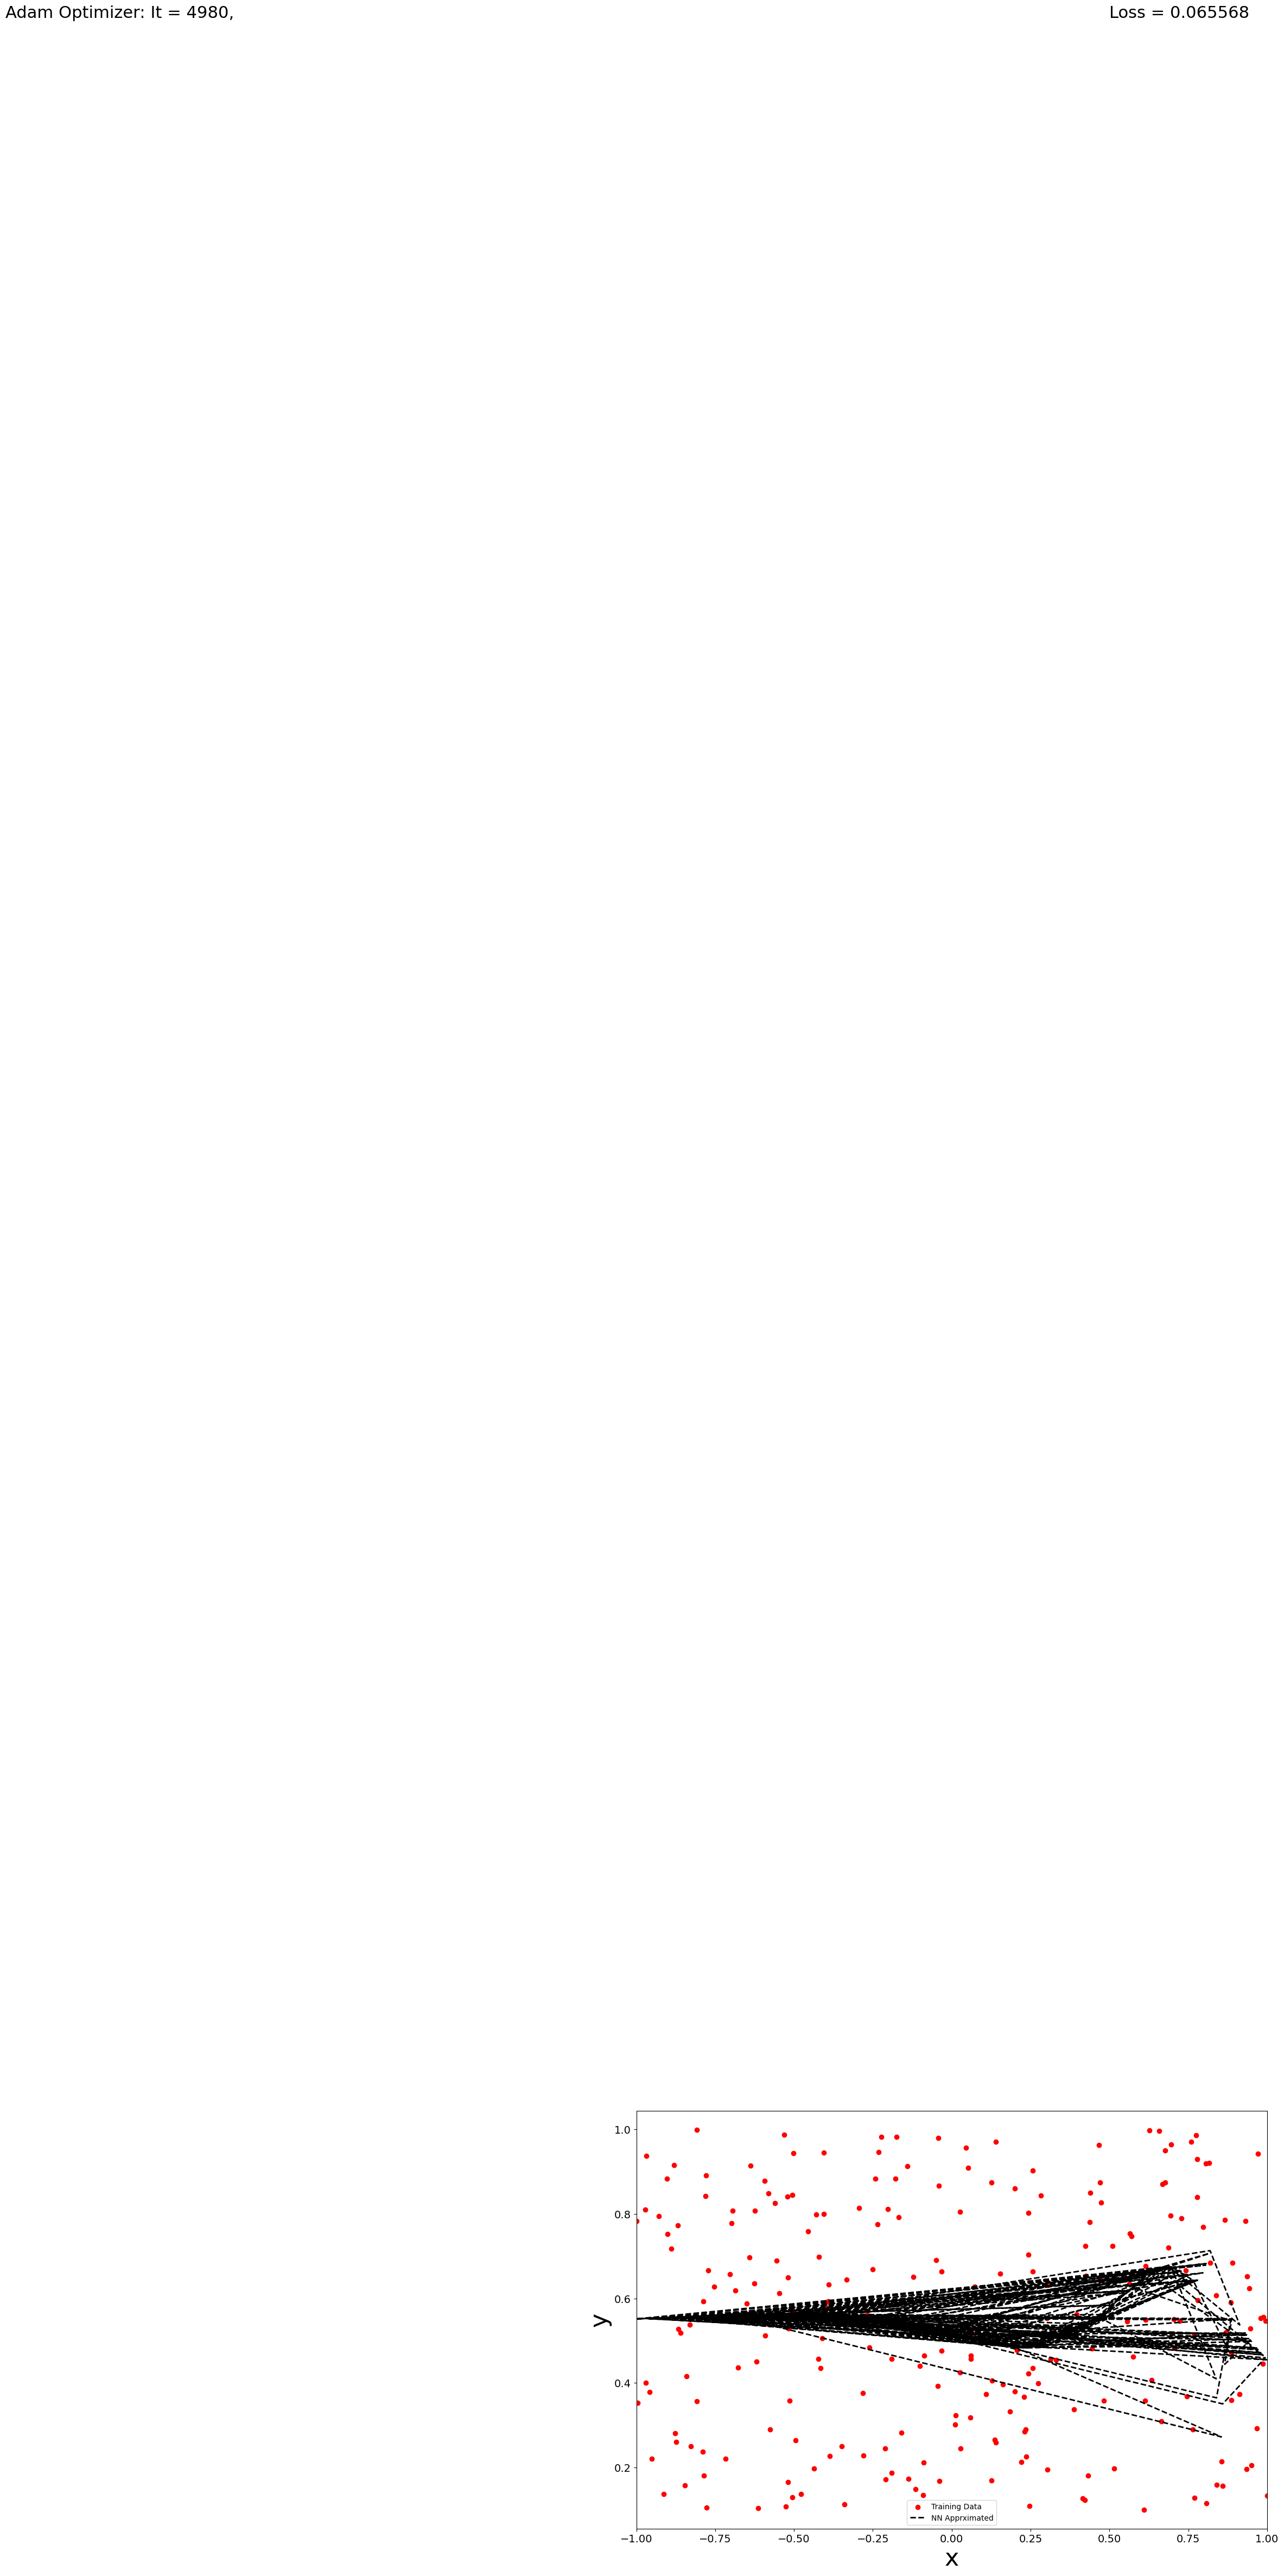

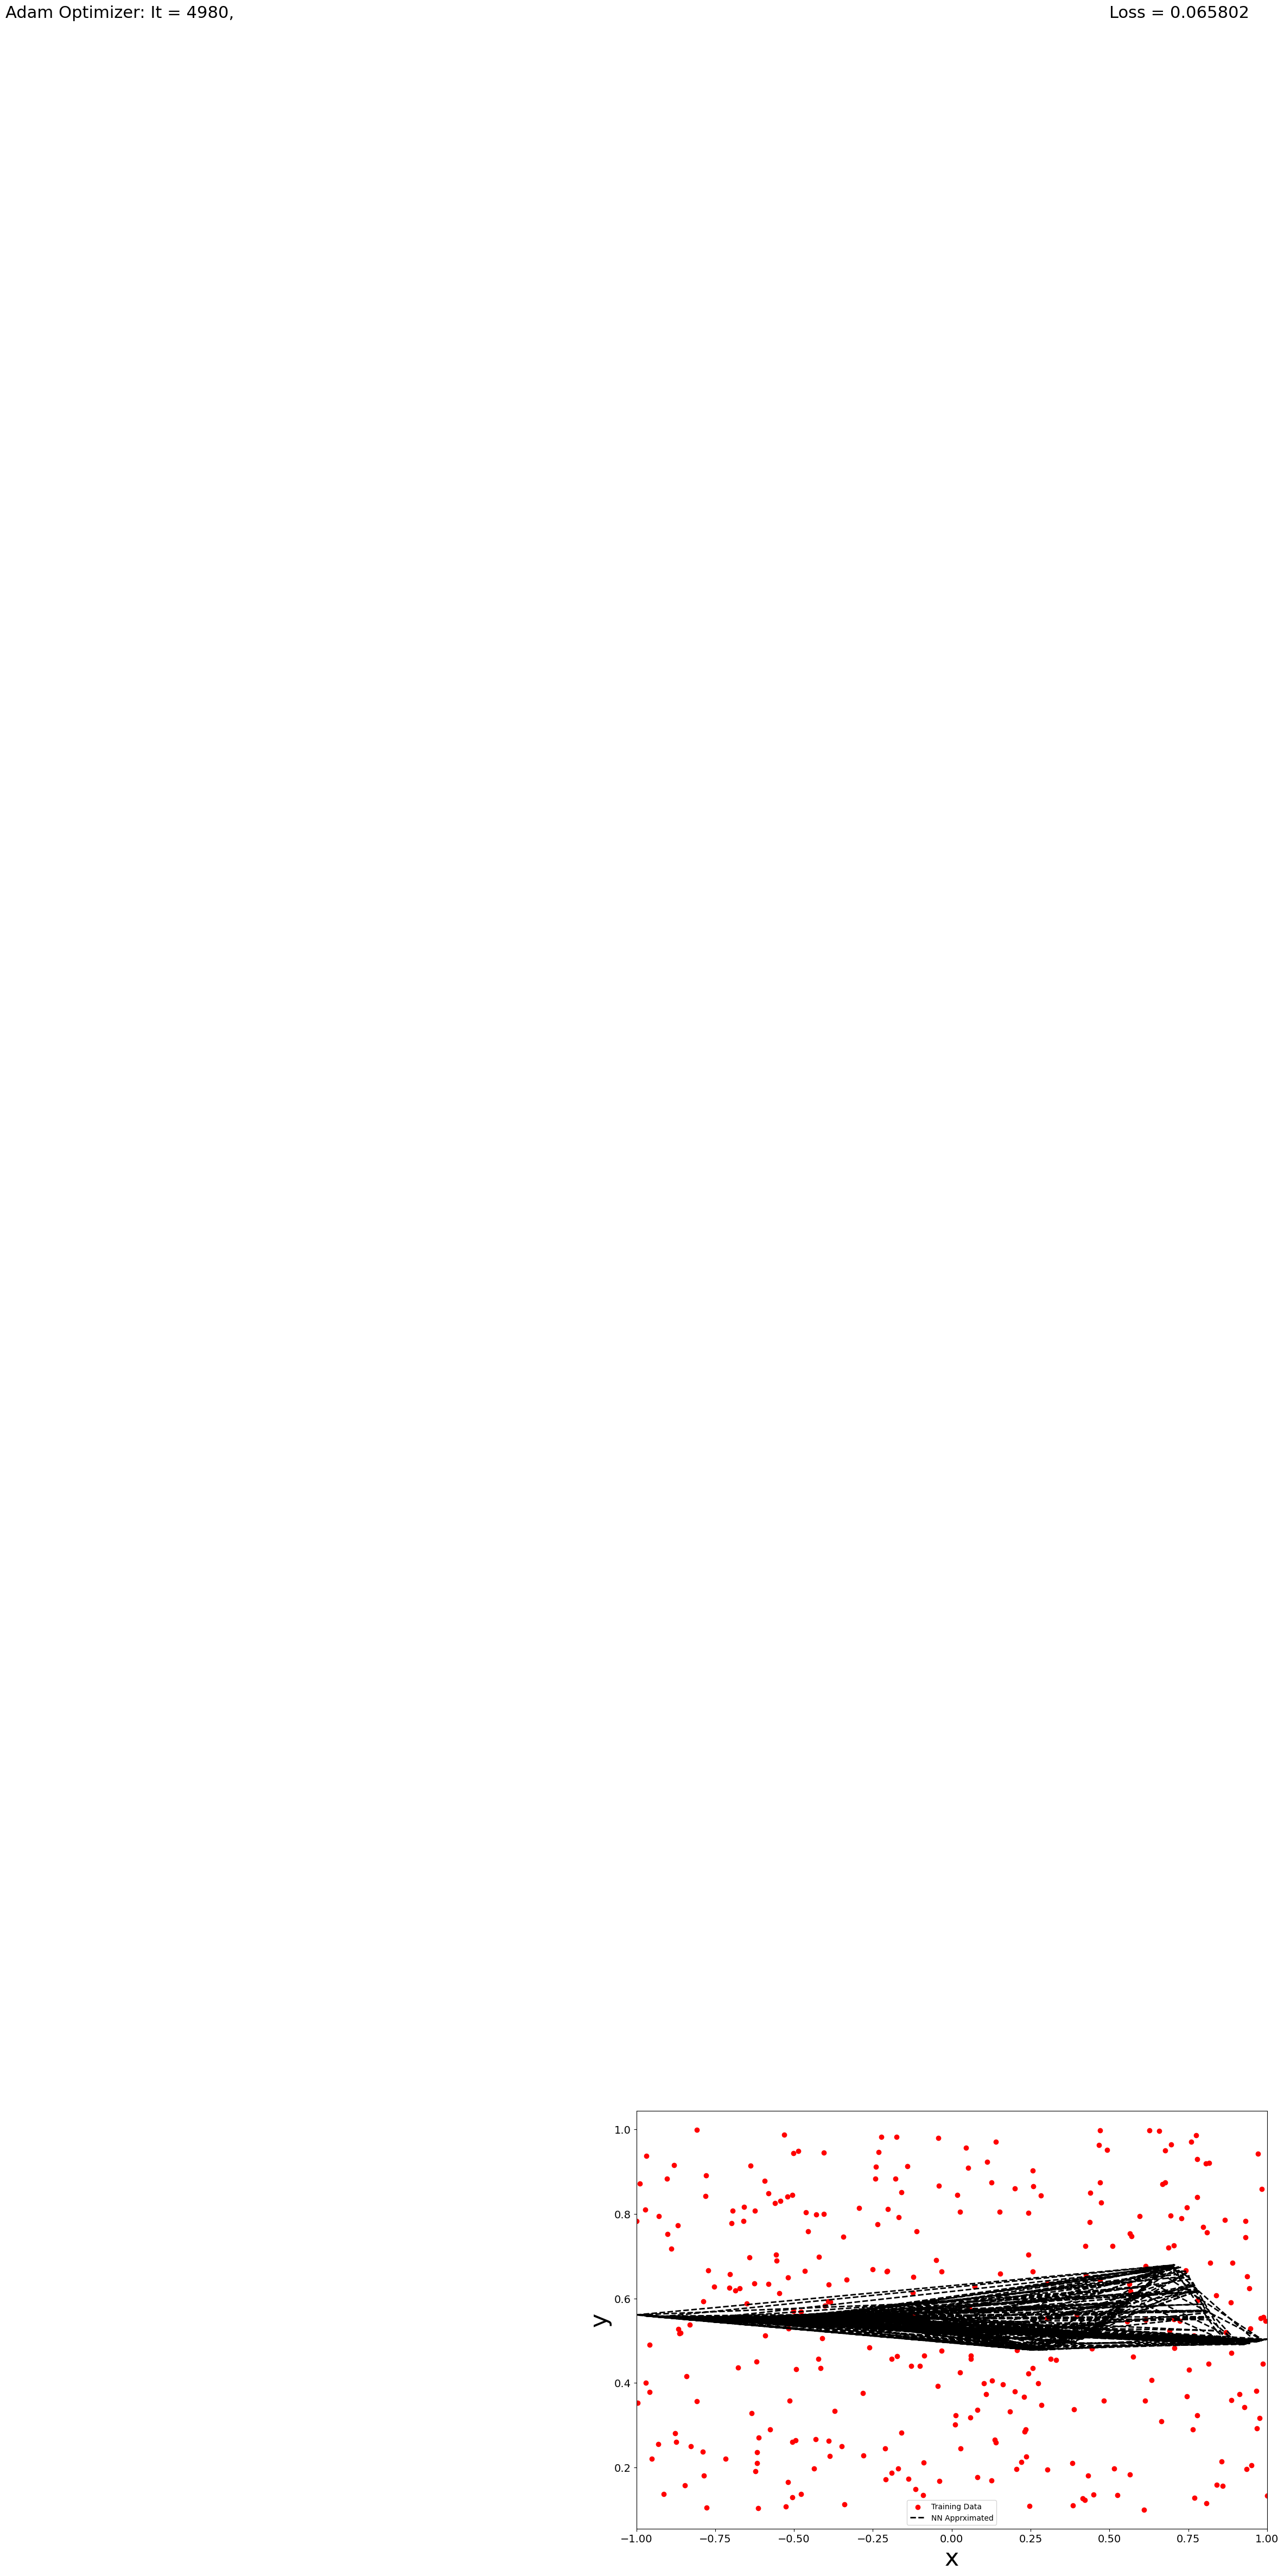

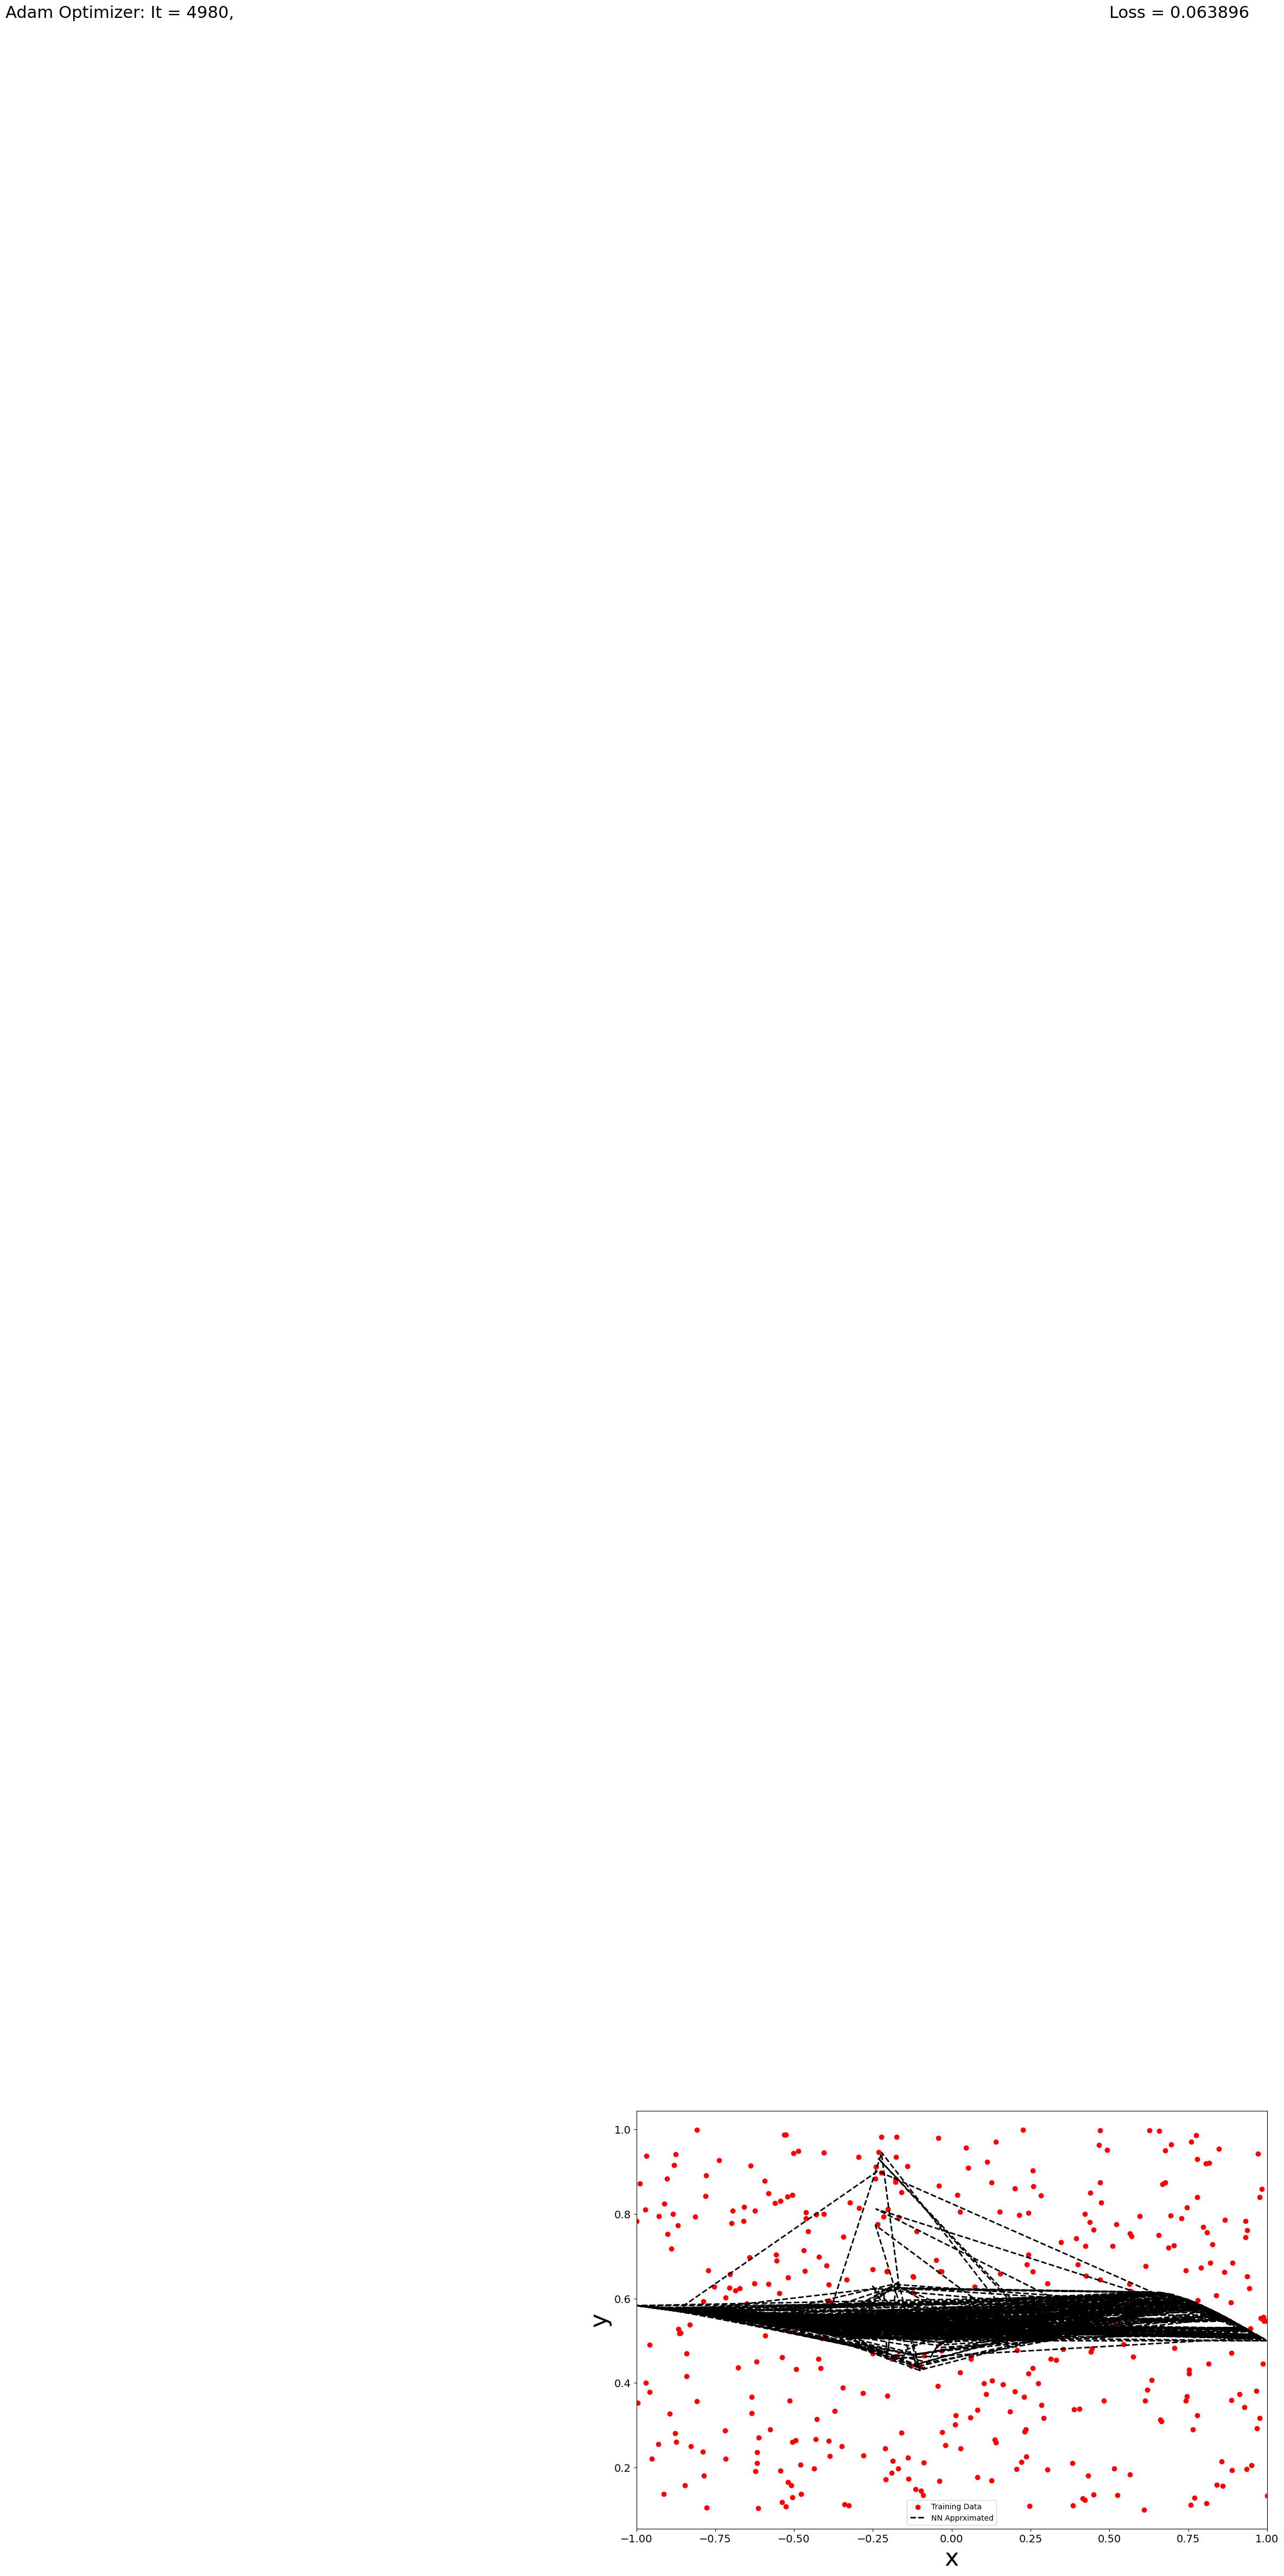

In [63]:

### Train the model for different number num_data_training 
# def train_model(num_data_training, num_of_neurons, num_epochs, X_train, Y_train):
nun_data_training = range(100,400,70)
num_epochs = 5000
num_of_neurons = 32
error_list = []

loss = np.zeros((len(nun_data_training),num_epochs))
for i,num_data in enumerate(nun_data_training):
    lossij, error = train_test_model(num_data, num_of_neurons, num_epochs, X_train, Y_train, X_test, Y_test)
    error_list.append(error)
error_list

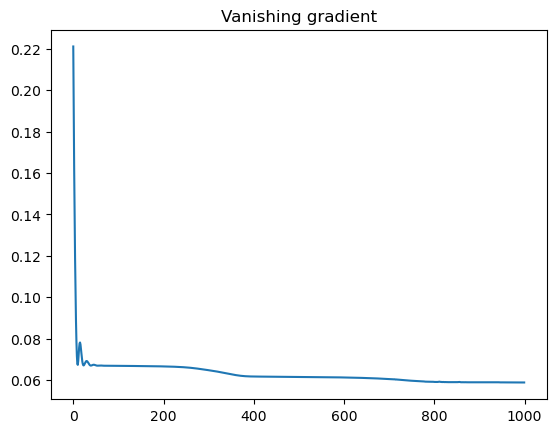

In [27]:
from matplotlib import pyplot

num_plot = 1
# pyplot.plot(loss[num_plot,:], color='blue', lw=2)
# pyplot.yscale('log')
# pyplot.show()

plt.plot(loss[num_plot,:],label="")
plt.title("Vanishing gradient??")
plt.show()
    

In [ ]:
plt.plot(X_train[picked,:],label=label)

plt.legend(loc = 'lower left')
# plt.title("Vanishing gradient")
plt.show()
    

   ### Plot $\theta(x)$ for different G values

In [ ]:
num_plots = 10
for i in range(num_plots):
  picked = np.random.randint(0, nun_data_training[-1]-1) 
  label =  'Sample number {}'.format(picked)
  plt.plot(X_train[picked,:],label=label)

plt.legend(loc = 'lower left')
# plt.title("Vanishing gradient")
plt.show()

### Ploting normalized $\theta(x)$ for a random G value

In [ ]:
num_plots = 1
for i in range(num_plots):
  picked = np.random.randint(0, nun_data_training[-1]) 
  label =  'Sample number {}'.format(picked)
  plt.plot(normalized_X_reduced_train[picked,:],label=label)
plt.legend(loc = 'lower left')
# plt.title("Vanishing gradient")
plt.show()



### Ploting normalized $\theta(x_i)$ for all G values $ \forall i \in [1:8]$


In [ ]:
for i in range(num_col_Xr):
    label =  'Point number {} of the fin'.format(i+1)
    plt.scatter(normalized_X_reduced_train[:,i],normalized_Y_reduced_train,label=label)
plt.legend(loc = 'lower left')
# plt.title("Vanishing gradient")
plt.show()
